# Hotspots

Hotspots California map: 
- Wildifre-wildifreSmokePM2.5, 
- Heat-wildfire,
- Heat-PM2.5, 
- Wildifre-Heat-SmokePM2.5P

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns   
import plotting
hspts = plotting.get_hotspot_list()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_parquet("outputs/d2-events-2d5-230929.parquet") 
gdf = gpd.read_file('data/WesternUSCensusTract/CensusTract2020_WesternUS.shp')
gdf = gdf[['FIPS', 'POPULATION', 'STATE_ABBR']]
df = gdf.merge(df.reset_index(), left_on="FIPS", right_on="GEOID")

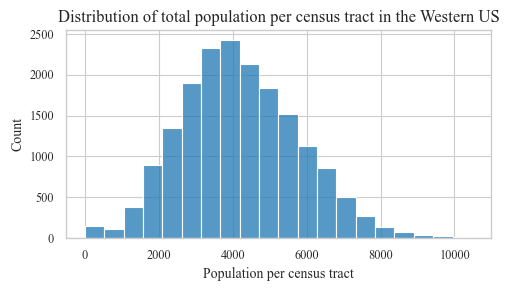

In [3]:
plt.rcParams["font.family"] = "Times New Roman"
axs = plt.subplots(figsize=(5.1, 3))
axs = sns.histplot(x=gdf[gdf["POPULATION"]<10500]["POPULATION"], bins=20)
axs.set_xlabel("Population per census tract", fontsize=10)
axs.set_ylabel("Count", fontsize=10)
axs.set_title("Distribution of total population per census tract in the Western US", fontsize=12)
plt.tight_layout()
# plt.savefig("figures/population_distribution.png", dpi=300)

## Total counts (tracts, days)

In [6]:
df = df[df.STATE_ABBR!='TX']

In [7]:
total_census_tracts = len(df.GEOID.unique())
total_census_tracts

18107

In [8]:
total_days = len(df)
total_days = total_days / total_census_tracts
total_days

5479.0

In [9]:
total_years = 15

In [10]:
df["COUNTY"] = df["GEOID"].apply(lambda x: x[:5])
print(df["COUNTY"].nunique())
df["STATE"] = df["GEOID"].apply(lambda x: x[:2])
print(df.STATE.nunique())
print(gdf.POPULATION.sum())

#df.STATE_ABBR.unique()

414
11
76334073


## Get Exposure days per census tract per year

In [11]:
hspts = ['wfday', 'heatday', 'smoke_pm_non_zero', 'smoke_pm_gt_five',
       'hw', '_hws', 'hs', 'hws', 'ws', 'hs5', 'hws5', 'ws5', 'heatday_2d',
       'smoke_pm_non_zero_2d', 'wfday_2d', '_hws_2d', 'hs_2d', 'hws_2d',
       'ws_2d', 'hw_2d', 'smoke_pm_gt_five_2d', 'hs_2d_5', 'ws_2d_5',
       'hws_2d_5']

In [12]:
df.groupby('STATE_ABBR')["FIPS"].count()

# Conclusion: The issue of finding an average exposure per census tract is that the states 
# in the western US has different number of census tracts. For instance, California has 9096 census tracts, while
# states like Idiho and Montana have less than 500 census tracts.

STATE_ABBR
AZ     9670435
CA    49836984
CO     7928113
ID     2498424
MT     1747801
NM     3353148
NV     4268141
OR     5429689
UT     3922964
WA     9675914
WY      876640
Name: FIPS, dtype: int64

In [19]:
df = df[df['STATE_ABBR'] != 'TX']

In [13]:
total_years = 15

def compute_exposure(df, hspts):
    """Compute exposure based on given columns."""
    # Calculate exposure days multiplied by ct population for each column
    exposure = df[hspts].multiply(df["POPULATION"], axis=0)
    
    # Aggregate exposure information
    exposure_agg = {
        "total_exposure_person_days": exposure.sum(),
        "avg_exposure_person_days_per_ct": exposure.mean(),
        "exposure_person_day_per_year": exposure.sum() / total_years,
        "total_exposure_days": df[hspts].sum(),
        "total_exposure_days_per_year": df[hspts].sum() / total_years,
        "total_exposure_days_per_ct": df[hspts].mean()
    }
    return pd.DataFrame(exposure_agg)

exposure_person_day = compute_exposure(df, hspts).reset_index()
exposure_person_day.columns = ["value"] + list(exposure_person_day.columns[1:])
exposure_person_day = exposure_person_day.astype(int, errors='ignore')

exposure_person_day = exposure_person_day.applymap(
    lambda x: "{:,.0f}".format(x) if isinstance(x, (int, float)) else x)
exposure_person_day[['value', 
        "total_exposure_days", "total_exposure_days_per_year","total_exposure_days_per_ct",
       'total_exposure_person_days', 'exposure_person_day_per_year',
       'avg_exposure_person_days_per_ct',
       ]].loc[[0,1,2,8,4,6,7,5]]

/var/folders/lc/q1l1y0k176b0h_m5yz0s_r5w0000gn/T/ipykernel_2261/3670173299.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  exposure_person_day = exposure_person_day.applymap(


,value,total_exposure_days,total_exposure_days_per_year,total_exposure_days_per_ct,total_exposure_person_days,exposure_person_day_per_year,avg_exposure_person_days_per_ct
0,wfday,"115,632","7,708",0,"384,251,376","25,616,758",3
1,heatday,"2,005,773","133,718",0,"8,537,373,785","569,158,252",86
2,smoke_pm_non_zero,"7,223,911","481,594",0,"30,063,223,402","2,004,214,893",303
8,ws,"43,692","2,912",0,"136,525,088","9,101,672",1
4,hw,"3,133",208,0,"10,579,329","705,288",0
6,hs,"573,221","38,214",0,"2,414,815,138","160,987,675",24
7,hws,"2,313",154,0,"7,744,153","516,276",0
5,_hws,"8,727,583","581,838",0,"36,430,673,161","2,428,711,544",367


In [24]:
exposure_person_day = exposure_person_day.applymap(lambda x: "{:,.0f}".format(x) if isinstance(x, (int, float)) else x)
exposure_person_day

/var/folders/lc/q1l1y0k176b0h_m5yz0s_r5w0000gn/T/ipykernel_2261/364580950.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  exposure_person_day = exposure_person_day.applymap(lambda x: "{:,.0f}".format(x) if isinstance(x, (int, float)) else x)


,value,total_exposure_person_days,avg_exposure_person_days_per_ct,exposure_person_day_per_year,total_exposure_days,total_exposure_days_per_year,total_exposure_days_per_ct
0,wfday,"384,251,376",3,"25,616,758","115,632","7,708",0
1,heatday,"8,537,373,785",86,"569,158,252","2,005,773","133,718",0
2,smoke_pm_non_zero,"30,063,223,402",303,"2,004,214,893","7,223,911","481,594",0
3,smoke_pm_gt_five,"10,078,231,179",101,"671,882,078","2,419,380","161,292",0
4,hw,"10,579,329",0,"705,288","3,133",208,0
5,_hws,"36,430,673,161",367,"2,428,711,544","8,727,583","581,838",0
6,hs,"2,414,815,138",24,"160,987,675","573,221","38,214",0
7,hws,"7,744,153",0,"516,276","2,313",154,0
8,ws,"136,525,088",1,"9,101,672","43,692","2,912",0
9,hs5,"925,211,619",9,"61,680,774","219,943","14,662",0


In [25]:
df_epy = exposure_person_day[["value","total_exposure_days", "total_exposure_days_per_year", "total_exposure_person_days", "exposure_person_day_per_year"]]

In [141]:
36431528133/(8728005*76334073)

5.468194654291524e-05

In [26]:
from tabulate import tabulate
# for col in merged_df.select_dtypes(include=['float64']).columns:
#     merged_df[col] = merged_df[col].apply(lambda x: '{:.2f}'.format(x))

markdown_table = tabulate(df_epy, headers='keys', tablefmt='pipe', showindex=False)
print(markdown_table)

| value                | total_exposure_days   | total_exposure_days_per_year   | total_exposure_person_days   | exposure_person_day_per_year   |
|:---------------------|:----------------------|:-------------------------------|:-----------------------------|:-------------------------------|
| wfday                | 115,632               | 7,708                          | 384,251,376                  | 25,616,758                     |
| heatday              | 2,005,773             | 133,718                        | 8,537,373,785                | 569,158,252                    |
| smoke_pm_non_zero    | 7,223,911             | 481,594                        | 30,063,223,402               | 2,004,214,893                  |
| smoke_pm_gt_five     | 2,419,380             | 161,292                        | 10,078,231,179               | 671,882,078                    |
| hw                   | 3,133                 | 208                            | 10,579,329                   | 705,288    

| value                |   total_exposure_days |   total_exposure_days_per_year |   total_exposure_person_days |   exposure_person_day_per_year |
|:---------------------|----------------------:|-------------------------------:|-----------------------------:|-------------------------------:|
| wfday                |                115632 |                        7708.8  |                    384251376 |                         256.17 |
| heatday              |               2005979 |                      133732    |                   8537791141 |                        5691.86 |
| smoke_pm_non_zero    |               7224168 |                      481611    |                  30063744084 |                       20042.5  |
| smoke_pm_gt_five     |               2419449 |                      161297    |                  10078370973 |                        6718.91 |
| hw                   |                  3133 |                         208.87 |                     10579329 |                           7.05 |
| _hws                 |               8728005 |                      581867    |                  36431528133 |                       24287.7  |
| hs                   |                573262 |                       38217.5  |                   2414898204 |                        1609.93 |
| hws                  |                  2313 |                         154.2  |                      7744153 |                           5.16 |
| ws                   |                 43692 |                        2912.8  |                    136525088 |                          91.02 |
| hs5                  |                219955 |                       14663.7  |                    925235931 |                         616.82 |
| hws5                 |                  1320 |                          88    |                      4341827 |                           2.89 |
| ws5                  |                 19280 |                        1285.33 |                     58618684 |                          39.08 |
| heatday_2d           |               2968398 |                      197893    |                  12637725047 |                        8425.15 |
| smoke_pm_non_zero_2d |              10364963 |                      690998    |                  43214680167 |                       28809.8  |
| wfday_2d             |                197017 |                       13134.5  |                    666341221 |                         444.23 |
| _hws_2d              |              12335048 |                      822337    |                  51554712349 |                       34369.8  |
| hs_2d                |               1109065 |                       73937.7  |                   4683871555 |                        3122.58 |
| hws_2d               |                  5482 |                         365.47 |                     18892293 |                          12.59 |
| ws_2d                |                 84732 |                        5648.8  |                    274845401 |                         183.23 |

In [27]:
# total population

df["POPULATION"].sum() 

418223285513

In [35]:
df_ecy = plotting.get_hotspopt_dict()

In [39]:
df_ecy = pd.DataFrame(df_ecy).transpose()
df_ecy.reset_index(inplace=True)
df_ecy.rename(columns={'index': 'value'}, inplace=True)

In [41]:
merged_df = df_ecy.merge(df_epy, on=["value"])
merged_df

,value,title,title_map,total_exposure_days,total_exposure_days_per_year,total_exposure_person_days,exposure_person_day_per_year
0,wfday,wildfire,Total days of wildfire,"115,632","7,708","384,251,376","25,616,758"
1,heatday,heat,Total days of heat,"2,005,773","133,718","8,537,373,785","569,158,252"
2,smoke_pm_non_zero,smoke_pm_non_zero,Total days of smoke $PM_{2.5}$,"7,223,911","481,594","30,063,223,402","2,004,214,893"
3,smoke_pm_gt_five,smoke_pm_gt_five,Total days of wildfire smoke (over >5μg/$m^3$),"2,419,380","161,292","10,078,231,179","671,882,078"
4,hws,heat_wildfire_smoke_pollution_non_zero,"Total days of heat, wildfire and smoke $PM_{2....","2,313",154,"7,744,153","516,276"
5,hs,heat_smoke_pollution_non_zero,Total days of heat and smoke $PM_{2.5}$ concur...,"573,221","38,214","2,414,815,138","160,987,675"
6,hw,heat_wildfire,Total days of heat and wildfire concurrence,"3,133",208,"10,579,329","705,288"
7,ws,wildfire_smoke_pollution_non_zero,Total days of wildfire & smoke $PM_{2.5}$,"43,692","2,912","136,525,088","9,101,672"
8,_hws,heat_or_wildfire_or_smoke_pollution,Total days of heat or wildfire or smoke $PM_{2...,"8,727,583","581,838","36,430,673,161","2,428,711,544"
9,hs5,heat_smoke_pollution_over_five,Total days of heat and smoke $PM_{2.5}$ (over ...,"219,943","14,662","925,211,619","61,680,774"


## Merge tables and add full exposure name

In [21]:
temp_dict = {}
hsptdict = plotting.get_hotspopt_dict()

# get full name of the exposure
for key in hsptdict.keys():
    temp_dict[key] = hsptdict[key]['title_map']

merged_df['value_full'] = merged_df['value'].replace(temp_dict)

NameError: name 'merged_df' is not defined

In [18]:
merged_df = merged_df[["value_full", "avg_census", "exposure_person_day_per_year", "exposure_person_day_per_year_per_ct"]]

| value_full                                                                      |   avg_census |   exposure_person_day_per_year |   exposure_person_day_per_year_per_ct |
|:--------------------------------------------------------------------------------|-------------:|-------------------------------:|--------------------------------------:|
| Total days of wildfire                                                          |         0.43 |                         115632 |                                  6.39 |
| Total days of heat                                                              |         7.39 |                        2005979 |                                110.78 |
| Total days of smoke $PM_{2.5}$                                                  |        26.6  |                        7224168 |                                398.95 |
| Total days of smoke $PM_{2.5}$ (over >5μg/$m^3$)                                |         8.91 |                        2419449 |         

| value_full                                                                      |   avg_census |   exposure_person_day_per_year |   exposure_person_day_per_year_per_ct |
|:--------------------------------------------------------------------------------|-------------:|-------------------------------:|--------------------------------------:|
| Total days of wildfire                                                          |         0.43 |                         115632 |                                  6.39 |
| Total days of heat                                                              |         7.39 |                        2005979 |                                110.78 |
| Total days of smoke $PM_{2.5}$                                                  |        26.6  |                        7224168 |                                398.95 |
| Total days of smoke $PM_{2.5}$ (over >5μg/$m^3$)                                |         8.91 |                        2419449 |                                133.61 |
| Total days of heat and wildfire concurrence                                     |         0.01 |                           3133 |                                  0.17 |
| Total days of heat or wildfire or smoke $PM_{2.5}$                              |        32.13 |                        8728005 |                                482    |
| Total days of heat and smoke $PM_{2.5}$ concurrence                             |         2.11 |                         573262 |                                 31.66 |
| Total days of heat, wildfire and smoke $PM_{2.5}$ concurrence                   |         0.01 |                           2313 |                                  0.13 |
| Total days of wildfire & smoke $PM_{2.5}$                                       |         0.16 |                          43692 |                                  2.41 |
| Total days of heat and smoke $PM_{2.5}$ (over >5μg/$m^3$) concurrence           |         0.81 |                         219955 |                                 12.15 |
| Total days of heat, wildfire and smoke $PM_{2.5}$ (over >5μg/$m^3$) concurrence |         0    |                           1320 |                                  0.07 |
| Total days of wildfire and smoke $PM_{2.5}$ (over >5μg/$m^3$) concurrence       |         0.07 |                          19280 |                                  1.06 |
| Total days of heat (2D)                                                         |        10.93 |                        2968398 |                                163.93 |
| Total days of smoke $PM_{2.5}$ (non zero) (2D)                                  |        38.16 |                       10364963 |                                572.4  |
| Total days of wildfire (2D)                                                     |         0.73 |                         197017 |                                 10.88 |
| Total days of heat or wildfire or smoke $PM_{2.5}$ (2D)                         |        45.41 |                       12335048 |                                681.19 |
| Total days of heat and non-zero smoke $PM_{2.5}$ concurrence (2D)               |         4.08 |                        1109065 |                                 61.25 |
| Total days of heat, wildfire and non-zero smoke $PM_{2.5}$ concurrence (2D)     |         0.02 |                           5482 |                                  0.3  |
| Total days of wildfire & smoke $PM_{2.5}$ (2D)                                  |         0.31 |                          84732 |                                  4.68 |

## State Stats

In [46]:
df = gpd.read_file("outputs/d2-events-2d-230929_SVI_shapefile.geojson")

In [59]:
mhspts = ['heatday','wfday',
 'smoke_pm_non_zero',
 'hw','hs','ws','hws',
 ]

N_years = 15

# Table 2 - Total exposure tract-days per state per year

In [61]:
# Group by state and sum the exposure days
total_exposure_per_state = df.groupby('ST_ABBR')[mhspts].sum().reset_index()
# Print the result
total_exposure_per_state[mhspts] = (total_exposure_per_state[mhspts]/N_years).round(0).astype(int)
total_exposure_per_state

,ST_ABBR,heatday,wfday,smoke_pm_non_zero,hw,hs,ws,hws
0,AZ,15832,819,25633,39,3532,247,25
1,CA,67866,2334,232190,48,16677,826,35
2,CO,11950,337,43976,7,4413,100,4
3,ID,2826,892,20471,16,1391,413,13
4,MT,1582,622,15988,14,942,302,12
5,NM,6161,363,13701,19,1607,116,13
6,NV,6427,134,16262,11,1728,57,8
7,OR,8153,1068,36194,29,3002,418,24
8,TX,14,0,17,0,3,0,0
9,UT,5325,257,18440,8,1919,98,6


In [62]:
total_exposure_per_state.sort_values(by='hw', ascending=False)[["ST_ABBR","hw"]]

,ST_ABBR,hw
1,CA,48
0,AZ,39
7,OR,29
5,NM,19
3,ID,16
4,MT,14
10,WA,13
6,NV,11
9,UT,8
2,CO,7


## Total person-days per state

Table S3

In [63]:
for column in mhspts:
    df[column] = df[column] * df['E_TOTPOP']

In [64]:
# Group by state and sum the person-days
total_person_days_per_state = df.groupby('ST_ABBR')[mhspts].sum()
total_person_days_per_state = (total_person_days_per_state/N_years).round(2)
total_person_days_per_state = total_person_days_per_state.div(1000000).round(2)
total_person_days_per_state

,heatday,wfday,smoke_pm_non_zero,hw,hs,ws,hws
ST_ABBR,,,,,,,
AZ,64.10,2.14,101.60,0.11,14.15,0.75,0.08
CA,297.62,8.67,993.58,0.19,72.54,2.69,0.14
CO,48.18,1.02,172.72,0.02,17.79,0.28,0.01
ID,11.12,2.89,77.94,0.05,5.48,1.27,0.04
MT,5.52,1.63,51.84,0.04,3.22,0.73,0.03
NM,21.74,1.06,46.18,0.05,5.57,0.30,0.03
NV,25.56,0.38,60.48,0.03,6.69,0.16,0.03
OR,35.38,3.52,149.38,0.10,12.86,1.33,0.08
TX,0.02,0.00,0.03,0.00,0.00,0.00,0.00


In [65]:
total_person_days_per_state = total_person_days_per_state.reset_index()

In [66]:
total_person_days_per_state.sort_values(by='hws', ascending=False)[["ST_ABBR","hws"]]

,ST_ABBR,hws
1,CA,0.14
0,AZ,0.08
7,OR,0.08
3,ID,0.04
4,MT,0.03
5,NM,0.03
6,NV,0.03
10,WA,0.03
9,UT,0.02
11,WY,0.02


## Mean person-days per census tract

In [43]:
df = pd.read_parquet("outputs/d2-events-2d-230929.parquet") 
gdf = gpd.read_file('data/WesternUSCensusTract/CensusTract2020_WesternUS.shp')
gdf = gdf[['FIPS', 'POPULATION', 'STATE_ABBR']]
# Groupby operation

data = df[mhspts + ['GEOID']]
# sum exposure days per GEOID (census tract (ct) number)
data = data.groupby('GEOID').sum()
df1 = gdf.merge(data, left_on="FIPS", right_on="GEOID")

In [67]:
data = df1[mhspts + ['POPULATION', 'STATE_ABBR']]

Montana records 751 days per census tract of exposure to wildfire smoke but only 29 days per census tract of direct wildfire impact. Similarly, Colorado registers 445 days per census tract of wildfire smoke exposure while only experiencing 3 days per census tract of actual wildfires. 

In [68]:
df.groupby('ST_ABBR')[mhspts].mean().round(2)

,heatday,wfday,smoke_pm_non_zero,hw,hs,ws,hws
ST_ABBR,,,,,,,
AZ,544786.29,18226.81,863481.64,970.25,120281.45,6350.31,675.18
CA,490847.18,14307.03,1638674.00,318.55,119634.09,4439.78,230.02
CO,499476.47,10562.39,1790412.44,245.69,184408.39,2947.44,148.31
ID,365651.23,94994.02,2563768.54,1741.84,180136.18,41832.22,1448.89
MT,259563.90,76424.94,2437748.14,1865.81,151417.62,34420.07,1501.99
NM,532950.23,26025.83,1131873.03,1235.93,136584.78,7439.07,827.05
NV,492203.91,7294.65,1164551.76,650.19,128774.27,3174.85,487.51
OR,535512.41,53322.32,2261054.48,1451.56,194615.26,20106.16,1177.74
TX,370800.00,0.00,462600.00,0.00,73800.00,0.00,0.00


In [70]:
df[["ST_ABBR"] + mhspts]

,ST_ABBR,heatday,wfday,smoke_pm_non_zero,hw,hs,ws,hws
0,AZ,169389,3422,694666,0,46197,0,0
1,AZ,754722,49221,2389953,0,229698,21876,0
2,AZ,197310,282811,2703147,0,46039,98655,0
3,AZ,834705,80379,2603043,0,253503,49464,0
4,AZ,762720,0,1570840,0,217920,0,0
...,...,...,...,...,...,...,...,...
18102,WY,237424,362384,2696012,6248,149952,99968,3124
18103,WY,225331,0,1338600,0,116012,0,0
18104,WY,252644,18046,1613828,0,136634,7734,0
18105,WY,324324,111384,2807532,22932,193284,52416,22932


In [184]:
data[mhspts] = data[mhspts].multiply(data['POPULATION'], axis=0)

/var/folders/lc/q1l1y0k176b0h_m5yz0s_r5w0000gn/T/ipykernel_48083/1027940323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[mhspts] = data[mhspts].multiply(data['POPULATION'], axis=0)


In [186]:
temp = data[data.STATE_ABBR != "TX"].groupby('STATE_ABBR').sum().divide(1000000, axis=0).round(2).reset_index()
temp

,STATE_ABBR,wfday,heatday,smoke_pm_non_zero,hw,hs,hws,ws,POPULATION
0,AZ,31.50,958.13,1515.75,1.67,210.96,1.18,11.48,7.15
1,CA,131.93,4472.64,15021.35,2.94,1092.17,2.12,41.16,39.51
2,CO,15.47,733.47,2633.59,0.37,271.10,0.22,4.33,5.77
3,ID,44.74,174.82,1223.32,0.81,86.10,0.67,19.62,1.84
4,MT,25.33,84.30,793.97,0.60,49.15,0.49,11.49,1.08
5,NM,16.36,329.74,700.19,0.80,84.47,0.53,4.75,2.12
6,NV,5.74,391.77,932.93,0.51,102.82,0.38,2.49,3.10
7,OR,53.60,537.74,2275.27,1.45,195.66,1.17,20.19,4.22
8,UT,14.42,370.16,1253.10,0.49,134.14,0.34,5.26,3.27
9,WA,36.28,438.10,3359.58,0.65,165.01,0.41,11.83,7.68


In [196]:
x = "smoke_pm_non_zero"
temp.sort_values(x, ascending=False)[:9][["STATE_ABBR", x]]

,STATE_ABBR,smoke_pm_non_zero
1,CA,15021.35
9,WA,3359.58
2,CO,2633.59
7,OR,2275.27
0,AZ,1515.75
8,UT,1253.10
3,ID,1223.32
6,NV,932.93
4,MT,793.97


In [164]:
data[mhspts] = data[mhspts].divide(1000, axis=0)

/var/folders/lc/q1l1y0k176b0h_m5yz0s_r5w0000gn/T/ipykernel_48083/2412843747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[mhspts] = data[mhspts].divide(1000, axis=0)


# Summer month plots

In [78]:
df2 = gpd.read_file("outputs/d2-events-2d-230929_SVI_shapefile.geojson")

In [74]:
df = pd.read_parquet("outputs/d2-events-2d5-230929.parquet") 

In [107]:
df2 = df2[df2['ST_ABBR'] != 'TX']

In [108]:
df = df[df.GEOID.isin(df2.FIPS)]

In [109]:
df.GEOID.nunique()

18106

In [110]:
temp = df.reset_index()
temp["month"] = temp["time"].dt.month

In [111]:
hspts = plotting.get_hotspot_list()

temp = temp.groupby("month")[hspts].sum()

x_dict = plotting.get_core_dict2()
# x_dict = {"wfday":"Wildfire","heatday":"Heat","smoke_pm_non_zero":"Wildfire smoke"}

In [112]:
# Calculate the sum of each column
column_sums = temp.sum()

# Divide each column by its sum and multiply by 100
df_normalized = temp.div(column_sums, axis='columns') * 100

In [113]:
import textwrap
plt.rcParams["font.family"] = 'sans-serif'
import seaborn as sns

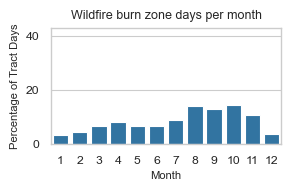

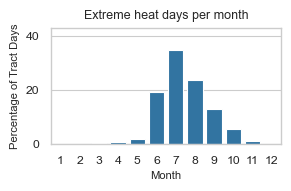

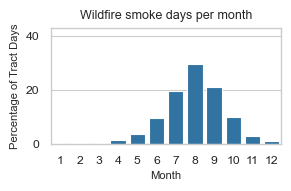

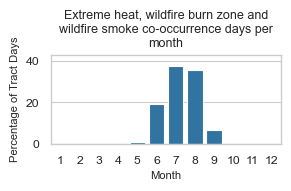

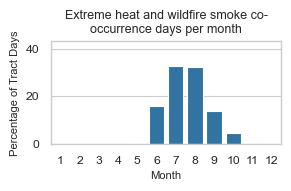

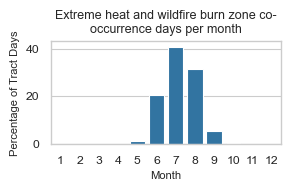

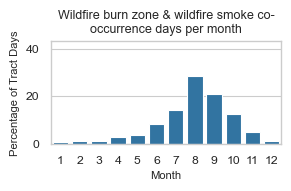

In [114]:
def plot_bar_chart(data, column_name):
    """Function to create and save a bar chart for a specific column."""
    if column_name=="month":
        return
    fig, ax = plt.subplots(figsize=(3, 2))

    sns.barplot(x=data.index, y=data[column_name], ax=ax) #, color="#a1c9f4")
    #ax.bar(data.index, data[column_name])
    #data[column_name].plot(kind='bar', ax=ax)  # Use ax=ax to place the plot in the correct subplot
    # set y-axis to limit
    ax.set_ylim(0, 43)
    
    wrapped_title = textwrap.fill(x_dict[column_name]["title_map"]+ ' days per month', 40)
    #fig.suptitle(wrapped_title, fontsize=14, fontweight="bold", y=0.95)
    
    plt.title(wrapped_title, fontsize=9)

    plt.ylabel('Percentage of Tract Days', fontsize=8)
    plt.xlabel('Month', fontsize=8)
    plt.tight_layout()

    # Uncomment this line if you want to save the figure
    #plt.savefig(f"figures/hist_{column_name}.png", dpi=300)
    plt.savefig(f'figures/pdf/fig3_{column_name}.pdf', format='pdf', dpi=300)
    plt.show()

# Loop through each column and create a bar chart
# temp_copy = temp.copy()
temp_copy = df_normalized.copy()
for col in x_dict.keys():
    plot_bar_chart(temp_copy, col)

    